In [11]:
import sys
import pymol
from pymol import cmd, stored

pymol.pymol_argv = ['pymol', '-qc'] # quiet / no GUI
stdout = sys.stdout
stderr = sys.stderr
pymol.finish_launching(['pymol', '-xiq'])
sys.stdout = stdout
sys.stderr = stderr

In [12]:
import Bio.PDB
import numpy as np
import os
from matplotlib import pyplot as plt
% matplotlib inline
%run 'ks01_Functions_only.ipynb'
notebook_prefix = 'ks16'
image_counter = Counter()

In [13]:
aa3 = "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR XXX".split()
ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
ascii_upper = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [14]:
def calc_dist_matrix(chain1, chain2, stripping=True, mode='min'):
    """Returns a matrix of C-alpha distances between two chains"""
    chain1_residues = rstrip_non_aa_residues(list(chain1.get_residues()))
    chain2_residues = rstrip_non_aa_residues(list(chain2.get_residues()))
    answer = np.zeros((len(chain1_residues), len(chain2_residues)), np.float)
    for row, residue_one in enumerate(chain1_residues):
        for col, residue_two in enumerate(chain2_residues) :
            answer[row, col] = get_distance_between_residues(residue_one, residue_two, mode=mode)
    return answer


def get_minimal_distances_in_a_complex(chains):
    distances = []
    chains = [chain for chain in chains if chain.id in ascii_letters]
    for chain1 in chains:
        for chain2 in chains:
            distances.append(calc_dist_matrix(chain1, chain2))
    return np.amin(np.array(distances), axis=0)

def strip_non_aa_residues(residues):
    for index, residue in enumerate(residues):
        if residue.resname not in aa3:
            pass
        else:
            break
    residues = residues[index:]
    return residues


def rstrip_non_aa_residues(residues):
    for index, residue in enumerate(residues):
        if residue.resname not in aa3:
            break
    residues = residues[:index]
    return residues

### Creating 24-mer using his3 prediction, transferring substrate and Mn from PDB 4LOM

In [15]:
swiss_mono_file = os.path.join(structure_predictions_folder, 'his3_24mer_assembly', 'his3_swiss_mono.pdb')
assembly_4lom_file = os.path.join(structure_predictions_folder, 'his3_24mer_assembly', '4lom_assembly.pdb')
his3_aligned_to_4lom_assembly_file = os.path.join(structure_predictions_folder, 'his3_24mer_assembly', 'his3_swiss_aligned_to_4lom_assembly.pdb')
his3_aligned_to_4lom_assembly_session_file = os.path.join(structure_predictions_folder, 'his3_24mer_assembly', 'his3_swiss_aligned_to_4lom_assembly.pse')

cmd.reinitialize()
cmd.load(assembly_4lom_file, '4lom_assembly')

# loading swiss monomers 24 times
for i in range(1,25):
    cmd.do("load %s, swiss-%s" % (swiss_mono_file, i))

# aligning swiss monomers to 4lom assembly
for i in range(1,25):
    cmd.do("align swiss-%s, 4lom_assembly, target_state=%s"  %(i, i))
    
# renaming chains because currently there is only chainA 
for i in range(1,25):
    cmd.do("alter swiss-%s, chain='%s'" %(i, ascii_upper[i-1]))

# splitting 24 states of 4LOM into chains, renaming every chain with the same letters as his3 chains
cmd.split_states('4lom_assembly')
for i in range(1,25):
    cmd.do("alter 4lom_assembly_%s, chain='%s'" %(str(i).zfill(4), ascii_upper[i-1]))

cmd.select('substrate', 'resn IYP')
cmd.select('Mn', 'resn MN')

to_save = ' or '.join(["swiss-%s" % i for i in range(1,25)] + ['substrate', 'Mn']) 
cmd.do('save %s, %s' %(his3_aligned_to_4lom_assembly_file, to_save))

save_session(his3_aligned_to_4lom_assembly_session_file)

 Save: wrote "/Users/karen/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/structure_predictions/his3_24mer_assembly/his3_swiss_aligned_to_4lom_assembly.pdb".
 Applying pse_export_version=1.720 compatibility


### Analyzing structure

In [16]:
structure = Bio.PDB.PDBParser().get_structure('his3_swiss_assembly', his3_aligned_to_4lom_assembly_file)
model = structure[0]

/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 37675.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/PDBParser.py:287: PDBConstructionWarning: PDBConstructionException: ('H_IYP', 301, ' ') defined twice at line 37675.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  % message, PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/PDBParser.py:287: PDBConstructionWarning: PDBConstructionException: ('H_ MN', 302, ' ') defined twice at line 37690.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  % message, PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/PDBParser.py:287: PDBConstructionWarning: PDBConstructionException: ('H_ MN', 303, ' ') defined twice at line 37691.
Exception ignored.
Some atoms or residues may be missing in 

In [17]:
substrates = [r for chain in model.get_chains() for r in chain if r.get_resname() == 'IYP']
mn = [r for chain in model.get_chains() for r in chain if r.get_resname() == ' MN']
lucas_pBon001=[7, 8, 9, 11, 13, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 38, 41, 56, 60, 62, 76, 77, 78, 79, 80, 81, 82, 85, 96, 97, 98, 99, 102, 104, 105, 106, 108, 110, 111, 112, 114, 115, 117, 119, 120, 121, 122, 131, 135, 137, 139, 140, 141, 142, 143, 144, 145, 147, 148, 151, 152, 154, 157, 160, 161, 163, 164, 165, 168, 169, 170, 172, 175, 177, 181, 189, 202, 203, 206, 207, 208, 209]

In [41]:
print len([r for chain in model.get_chains() for r in chain if 'MN' in r.get_resname().upper()])

72


In [29]:
import re

In [37]:
string = 'A10KA26S'
pattern = '(^\D\d+\D)(\D\d+\D$)'
match = re.match(pattern, string)

In [39]:
match.groups[0]

TypeError: 'builtin_function_or_method' object has no attribute '__getitem__'

In [28]:
reciprocal_sign_epistasis = pd.read_table(files_dump_folder + 'RepSign.tab')
reciprocal_sign_epistasis['mutation1'] = reciprocal_sign_epistasis['fused_mutations'].apply(lambda s: )

,index,fused_mutations
0,1,A10EA26S
1,1,A10KA26S
2,1,A10KA5E
3,1,A10KE5H
4,1,A10KE5K
5,1,A10KE5T
6,1,A10KF30L
7,1,A10TL9V
8,1,A26SA10E
9,1,A26SA10K


In [18]:
def get_distance_between_atoms(atom1, atom2):
    diff_vector  = atom1.coord - atom2.coord
    return np.sqrt(np.sum(diff_vector * diff_vector))


def get_distance_between_residues(residue_one, residue_two, mode='min'):
    assert mode in ['CA', 'min']
    if mode == 'CA':
        diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
        return np.sqrt(np.sum(diff_vector * diff_vector))
    if mode == 'min':
        distances = []
        for atom1 in residue_one.get_atom():
            for atom2 in residue_two.get_atom():
                distances.append(get_distance_between_atoms(atom1, atom2))
        return min(distances)

    
def get_distance_to_other_residues(residue, other_residues, mode='min'):
    distances = np.zeros(len(other_residues))
    for index, other_residue in enumerate(other_residues):
        distances[index] = get_distance_between_residues(residue, other_residue, mode=mode)
    return distances

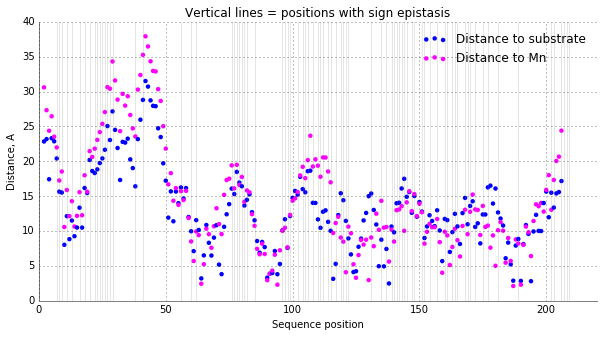

In [19]:
title = 'Sign epistasis vs distance to substrate and Mn'

substrate_color = 'blue'
mn_color = 'magenta'

sign_epistasis_dist_to_substrate = []
no_sign_epistasis_dist_to_substrate = []
sign_epistasis_dist_to_mn = []
no_sign_epistasis_dist_to_mn = []

plot_better()
residues = list(list(model.get_chains())[0].get_residues())
for index, residue in enumerate(strip_non_aa_residues(residues)):
    
    distance_to_substrate = min(get_distance_to_other_residues(residue, substrates))
    distance_to_mn = min(get_distance_to_other_residues(residue, mn))
    assert aa321[residue.get_resname()] == Scer_Uniprot[index+2 - 1]

    plt.scatter(index+2, distance_to_substrate, edgecolor='none', color=substrate_color)
    plt.scatter(index+2, distance_to_mn, edgecolor='none', color=mn_color)
    if index+2 in lucas_pBon001:
        sign_epistasis_dist_to_substrate.append(distance_to_substrate)
        sign_epistasis_dist_to_mn.append(distance_to_mn)
    else:
        no_sign_epistasis_dist_to_substrate.append(distance_to_substrate)
        no_sign_epistasis_dist_to_mn.append(distance_to_mn)

for position in lucas_pBon001:
    plt.axvline(position, ls='-', color='gray', alpha=0.2)

plt.title('Vertical lines = positions with sign epistasis')
plt.ylabel('Distance, A')
plt.xlabel('Sequence position')
plt.xlim(0,220)
plt.scatter(None, None, edgecolor='none', color='blue', label='Distance to substrate')
plt.scatter(None, None, edgecolor='none', color='magenta', label='Distance to Mn')
plt.legend(loc='upper right', frameon=False)
save_image(image_counter, title, figures_folder, notebook_prefix)

plt.savefig(figures_folder+'%s.pdf' %'_'.join(title.split()))

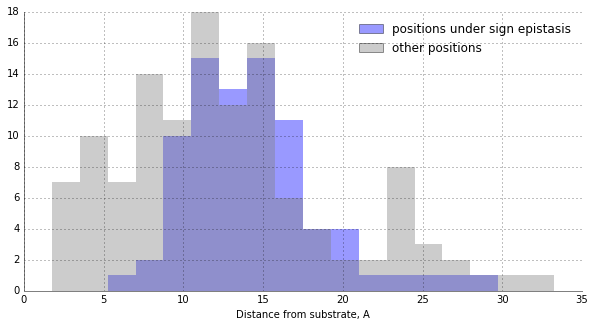

In [20]:
title = 'Sign epistasis vs distance to substrate histogram'

plot_better()
plt.hist(sign_epistasis_dist_to_substrate, range=(0,35), bins=20, label='positions under sign epistasis', 
         edgecolor='none', alpha=0.4, color=substrate_color)
plt.hist(no_sign_epistasis_dist_to_substrate, edgecolor='none', range=(0,35), bins=20, alpha=0.4, color='gray', label='other positions')
plt.xlabel('Distance from substrate, A')
plt.legend(loc='upper right', frameon=False)

save_image(image_counter, title, figures_folder, notebook_prefix)
plt.savefig(figures_folder+'%s.pdf' %'_'.join(title.split()))

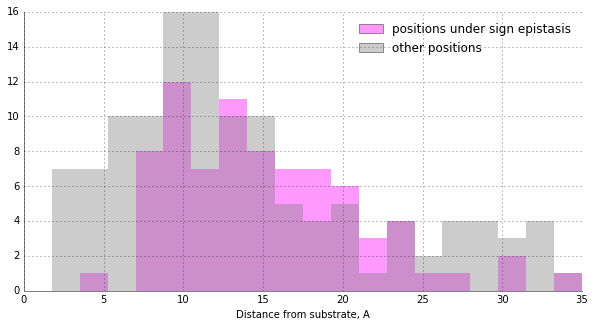

In [21]:
title = 'Sign epistasis vs distance to substrate histogram'

plot_better()
plt.hist(sign_epistasis_dist_to_mn, range=(0,35), bins=20, label='positions under sign epistasis', 
         edgecolor='none', alpha=0.4, color=mn_color)
plt.hist(no_sign_epistasis_dist_to_mn, edgecolor='none', range=(0,35), bins=20, alpha=0.4, color='gray', label='other positions')
plt.xlabel('Distance from nearest Mn atom, A')
plt.legend(loc='upper right', frameon=False)

save_image(image_counter, title, figures_folder, notebook_prefix)
plt.savefig(figures_folder+'%s.pdf' %'_'.join(title.split()))

In [31]:
from scipy import stats
print 'KS 2-sample test for distance substrate:\n', stats.ks_2samp(sign_epistasis_dist_to_substrate, no_sign_epistasis_dist_to_substrate)
print
print 'KS 2-sample test for distance Mn:\n',  stats.ks_2samp(sign_epistasis_dist_to_mn, no_sign_epistasis_dist_to_mn)

KS 2-sample test for distance substrate:
Ks_2sampResult(statistic=0.26650000000000001, pvalue=0.0014917283920581389)

KS 2-sample test for distance Mn:
Ks_2sampResult(statistic=0.2185, pvalue=0.015804600397267665)
